In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display

In [22]:
def gradients(outputs, inputs, order = 1):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1) # Recursively take gradients
    else:
        return outputs

def generate_2Dgrid(minimum1, maximum1, minimum2, maximum2, N):
    grid1 = np.linspace(minimum1, maximum1, N, dtype = np.float32)
    grid2 = np.linspace(minimum2, maximum2, N, dtype = np.float32)
    x0, y0 = np.meshgrid(grid1, grid2)
    x = torch.tensor(x0.reshape(N**2), requires_grad = True)
    y = torch.tensor(y0.reshape(N**2), requires_grad = True)
    return x, y

def plot_form(x, y, z, N):
    return map(lambda t: t.reshape(N,N).cpu().detach().numpy(), (x, y, z))


"""# 1. Automatic differentiation and optimization"""

In [35]:
# The ODE solution will be modelled as a NN with 1 hidden layer of 40 nodes 
# and output 2 values
gamma = 2.0
Bx = 0.75
resolution = 100
class MHD(nn.Module):
    def __init__(self):
        super(MHD, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 7),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.1)
                nn.init.constant_(m.bias, val = 0.0)
                
    def forward(self, t, x):
        tx = torch.stack((t,x), 1)
        #bdry = (abs(x) - 1).reshape(len(x), 1)
        return self.net(tx) #* bdry

# The loss function that will be used to train the NN will be constructed
# out of the DE
def initial_condition(x):
    if x < 0:
        return [1.0,0.0,0.0,0.0,1.0,0.0,1.0]
    else:
        return [0.125,0.0,0.0,0.0,-1.0,0.0,0.1]


def conserved(P):
    t_P = P.t()
    rho = t_P[0]
    vx = t_P[1]
    vy = t_P[2]
    vz = t_P[3]
    By = t_P[4]
    Bz = t_P[5]
    p = t_P[6]

    rhovx = vx*rho
    rhovy = vy*rho
    rhovz = vz*rho

    energy = (p/(gamma-1) + 1/2*(Bx**2+By**2+Bz**2) + rho/2*(vx**2+vy**2+vz**2))

    return torch.stack((rho, rhovx, rhovy, rhovz, By, Bz, energy)).t()
    #return torch.tensor(P)

def current(P):
    t_P = P.t()
    rho = t_P[0]
    vx = t_P[1]
    vy = t_P[2]
    vz = t_P[3]
    By = t_P[4]
    Bz = t_P[5]
    p = t_P[6]

    rhovx = vx*rho

    ps = p + 1/2*(Bx**2+By**2+Bz**2)
    energy = (p/(gamma-1) + 1/2*(Bx**2+By**2+Bz**2) + rho/2*(vx**2+vy**2+vz**2))

    return torch.stack((
        rhovx, 
        rhovx**2 + ps -Bx**2, 
        rhovx*vy - Bx*By, 
        rhovx*vz - Bx*Bz, 
        By*vx - Bx*vy, 
        Bz*vx - Bx*vz, 
        (energy+ps)*vx - Bx*(Bx*vx+By*vy+Bz*vz)
    )).t()

class MHDLoss(nn.Module):
    def __init__(self, approx_sol):
        super(MHDLoss, self).__init__()
        self.approx_sol = approx_sol
        self.conserved = conserved
        self.current = current
        
    def forward(self, t, x):

       # global test1, test2, test3, test4
      
        P = self.approx_sol(t, x)#.squeeze()
        U = self.conserved(P)
        J = self.current(P)

        eq = gradients(U, t) + gradients(J, x)

        # loss function associated with satisfying DE        
        eq_loss = (torch.flatten(eq))**2

        #define the initial values of t,x
        tinitial=torch.zeros(resolution)
        xinitial=torch.as_tensor([x[resolution*i] for i in range(resolution)])

        approx_sol_ic = self.approx_sol(tinitial,xinitial) #self.approx_sol(torch.zeros(x.detach().numpy().size), x)
        

        #loss function that constrains Initial Conditions
        #ic_loss = map(lambda elem : (elem[0]-1)**2 if elem[1] < -1 else (elem[0] - (1-elem[1]))**2 if elem[1] < 1 else x[0]**2, zip(ic, x))
        ic_loss =(approx_sol_ic - torch.as_tensor(list(map(initial_condition, xinitial))))**2

        return torch.mean(eq_loss)+2*resolution*torch.sum(ic_loss) #torch.mean(torch.cat((eq_loss, 2*ic_loss),dim=0)) #torch.mean(eq_loss.append() ) #

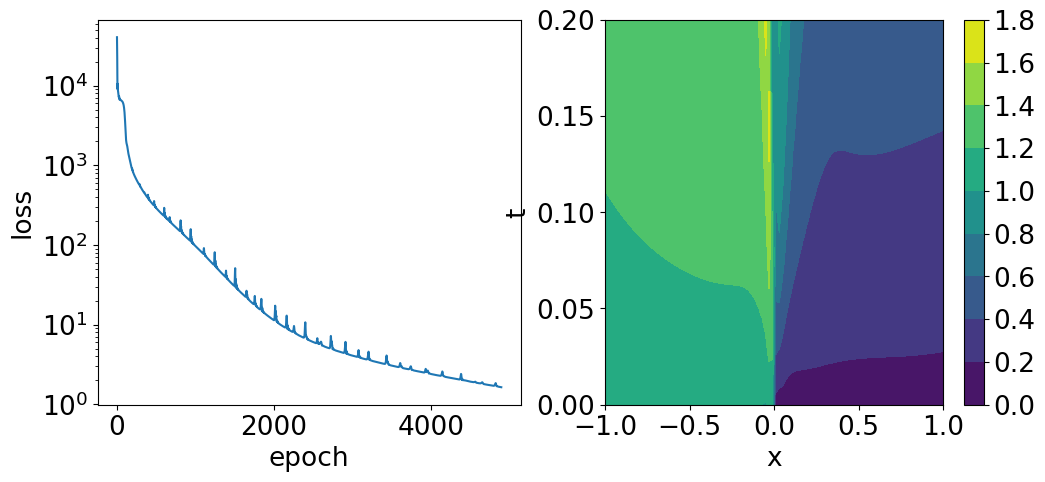

In [36]:
pde      = MHD()
pde_loss = MHDLoss(pde)
loss_hist = []

t, x = generate_2Dgrid(0, 0.2, -1, 1, resolution)
optimizer = optim.Adam(pde.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.1)**(1/5000))

################## Training and Plotting ##################
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 5));
font = {'size'   : 19}
plt.rc('font', **font)

p = None

for it in range(5000):
    try:
        optimizer.zero_grad()

        loss = pde_loss(t, x)
        loss_hist.append(loss.cpu().detach().numpy())

        loss.backward()
        optimizer.step()
        scheduler.step()
    
        if  it %100 == 0:
            t_plot, x_plot, u_plot = plot_form(x, t, pde(t, x).t()[0], resolution)
            
            ax1.cla()
            ax1.set_xlabel('epoch')
            ax1.set_ylabel('loss')
            ax1.set_yscale('log')
            ax1.plot(loss_hist)
            
            ax2.cla()
            ax2.set_xlabel('x')
            ax2.set_ylabel('t')
            p = ax2.contourf(t_plot, x_plot, u_plot)
            
            display.display(plt.gcf())
            display.clear_output(wait=True)

    except KeyboardInterrupt:
        break

fig.colorbar(p)
#hello

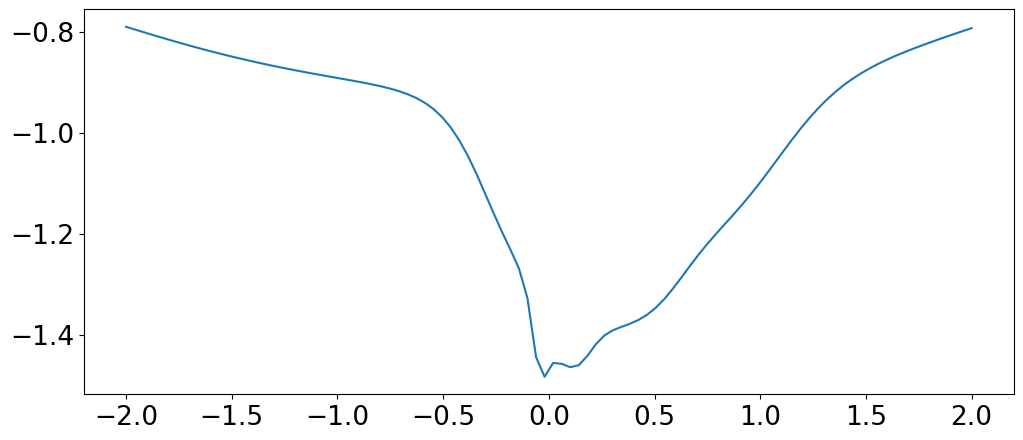

In [37]:
u = pde(0.2*torch.ones(resolution), torch.linspace(-1,1,resolution))
fig, (ax1) = plt.subplots(1,1, figsize = (12, 5));
ax1.plot(torch.linspace(-2,2,resolution), u.t().detach().numpy()[2])

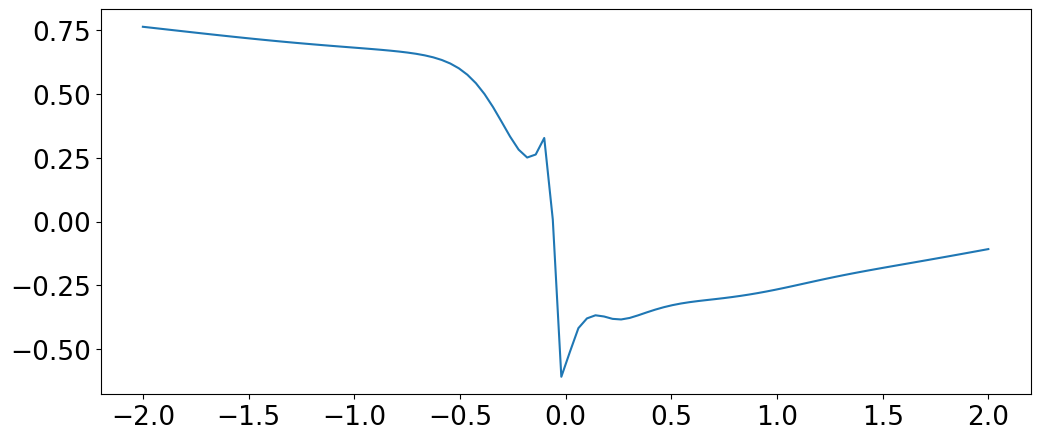

In [38]:
u = pde(0.2*torch.ones(resolution), torch.linspace(-1,1,resolution))
fig, (ax1) = plt.subplots(1,1, figsize = (12, 5));
ax1.plot(torch.linspace(-2,2,resolution), u.t().detach().numpy()[6])

In [ ]:
pde = MHD()
t = torch.ones(resolution, requires_grad=True)
x = torch.zeros(resolution, requires_grad=True)
gradients(conserved(pde(t, x)),t)
#output.grad
        

In [ ]:
t

In [ ]:
pp=pde(t,x).t()
trial=torch.einsum('i,j->ij',pp[0], pp[1])
trial.shape

In [ ]:
output

In [ ]:
pp=pde(t,x).t()
pp[0]

torch.stack((pp[0],pp[1]))

In [ ]:
torch.as_tensor(list(map(initial_condition, x))).shape

In [ ]:
torch.mean((pde(t, x) - torch.as_tensor(list(map(initial_condition, x))))**2)